# $$\color{red}{\text{Machine Learning}}$$

$$\color{orange}{\text{Expectation Maximization and Gaussian Mixture Model}}$$

$$\color{lime}{\text{Alireza Javid - 810198375}}$$

## $\color{deepskyblue}{\text{Import Libraries}}$

In [60]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.model_selection import GridSearchCV

## $\color{deepskyblue}{\text{Data Loading}}$

In [2]:
che_images=[]
mu_images=[]
for filename in os.listdir("Q6_Dataset\Images"):
    if (filename[0] == 'c'):
        che_images.append(cv2.mean(cv2.imread(os.path.join("Q6_Dataset\Images",filename))))
    else:
        mu_images.append(cv2.mean(cv2.imread(os.path.join("Q6_Dataset\Images",filename))))

## $\color{deepskyblue}{\text{GMM Model}}$

In this part, we utilize the Gaussian Mixture Model (GMM) algorithm with K=2 to fit separate models for each class based on the RGB features. We then plot the models along with their corresponding contours. It is evident from the plot that the mean of one Gaussian distribution in the first model is very close to the mean of the other Gaussian distribution in the second model for a different class. This proximity of means suggests that there may be some overlap or similarity between the two classes in terms of their RGB feature distribution.

In [3]:
ch_features = np.array(che_images)[:, [0, 2]]
K = 2
gmm1 = GaussianMixture(n_components=K)
gmm1.fit(ch_features)

GaussianMixture(n_components=2)

In [4]:
mu_features = np.array(mu_images)[:, [0, 2]]
K = 2
gmm2 = GaussianMixture(n_components=K)
gmm2.fit(mu_features)

GaussianMixture(n_components=2)

In [58]:
def plot_contour(model, features, label):
    lower_bound = min(min(features[:,0]), min(features[:,1]))
    upper_bound = max(max(features[:,0]), max(features[:,1]))
    scale = np.linspace(lower_bound, upper_bound,100)
    x, y = np.meshgrid(scale, scale)
    Z = np.zeros_like(x)
    for i in range(model.n_components):
        Z += model.weights_[i] * multivariate_normal.pdf(np.dstack((x, y)), mean=model.means_[i], cov=model.covariances_[i])
    color = 'red' if label == 'Manchester United Class' else 'blue'
    levels_ = np.linspace(np.min(Z), np.max(Z), 16)
    alpha_ = 0.5
    plt.contour(x, y, Z, levels=levels_, alpha=alpha_, colors=color, linestyles='dashed')
    for i in range(model.n_components):
        plt.plot(model.means_[i, 0], model.means_[i, 1], 'ko')

def plot_gmm(gmm, X, color, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=color, s=40, cmap='viridis', zorder=2, label=label)
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    plot_contour(gmm, X, label)

### $\color{deepskyblue}{\text{Contour Plot}}$

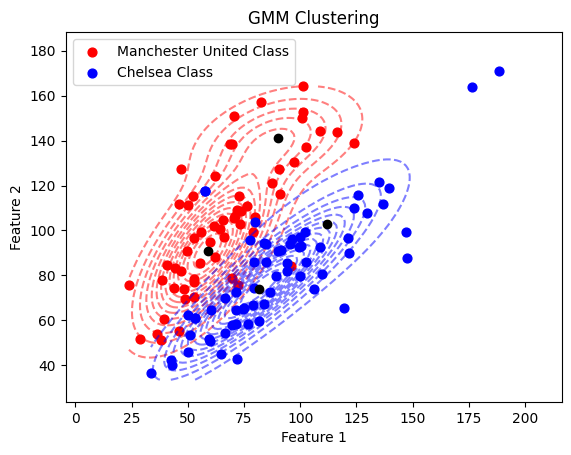

In [59]:
plot_gmm(gmm1, mu_features,'red', 'Manchester United Class')
plot_gmm(gmm2, ch_features,'blue', 'Chelsea Class')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('GMM Clustering')
plt.show()

### $\color{deepskyblue}{\text{GMM Parameters}}$

In [81]:
def print_parameters_of_GMM(model):
    list_of_means = model.means_
    list_of_covs = model.covariances_
    list_of_w = model.weights_

    for i, (mean_i, cov_i, w_i) in enumerate(zip(list_of_means, list_of_covs, list_of_w)):
        print('Component', i + 1, 'parameters:')
        print('Weight:', w_i)
        print('Mean:', mean_i)
        print('Covariance matrix:')
        print(str(cov_i) + '\n')

In [82]:
print_parameters_of_GMM(gmm1)

Component 1 parameters:
Weight: 0.7554506728040803
Mean: [58.80821217 90.98118952]
Covariance matrix:
[[280.6650719  226.98783562]
 [226.98783562 416.69323113]]

Component 2 parameters:
Weight: 0.2445493271959197
Mean: [ 89.94134538 140.91862308]
Covariance matrix:
[[449.11249752 102.39718695]
 [102.39718695 169.8513045 ]]



In [83]:
print_parameters_of_GMM(gmm2)

Component 1 parameters:
Weight: 0.2703984412175727
Mean: [111.79949486 102.87932864]
Covariance matrix:
[[1520.58716804  667.66808135]
 [ 667.66808135  895.60626832]]

Component 2 parameters:
Weight: 0.7296015587824272
Mean: [81.61750163 74.00116811]
Covariance matrix:
[[555.7617593  426.9072995 ]
 [426.9072995  413.48403773]]



## $\color{deepskyblue}{\text{Choose the Best Value for k}}$

### $\color{deepskyblue}{\text{Using BIC and AIC}}$

In [69]:
def evaluate_gmm(X, class_name):
    # Define the range of values for k to be evaluated
    k_values = range(1, 11)

    # Initialize variables to store BIC and AIC scores
    bic_scores = []
    aic_scores = []

    # Iterate over different values of k
    for k in k_values:
        gmm = GaussianMixture(n_components=k, random_state=0)
        gmm.fit(X)
        
        # Calculate BIC and AIC scores
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
    # Plot the BIC and AIC scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, bic_scores, 'bo-', label='BIC')
    plt.plot(k_values, aic_scores, 'go-', label='AIC')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Score')
    plt.title('BIC and AIC Scores for GMM of ' + str(class_name))
    plt.legend()

    # Find the best value of k based on BIC and AIC
    best_k_bic = k_values[np.argmin(bic_scores)]
    best_k_aic = k_values[np.argmin(aic_scores)]

    # Add markers for the best values of k
    plt.plot(best_k_bic, np.min(bic_scores), 'bo', markersize=10, label='Best k (BIC)')
    plt.plot(best_k_aic, np.min(aic_scores), 'go', markersize=10, label='Best k (AIC)')

    # Show the plot
    plt.show()

    # Print the best values of k based on BIC and AIC
    print("Best value of k based on BIC:", best_k_bic)
    print("Best value of k based on AIC:", best_k_aic)

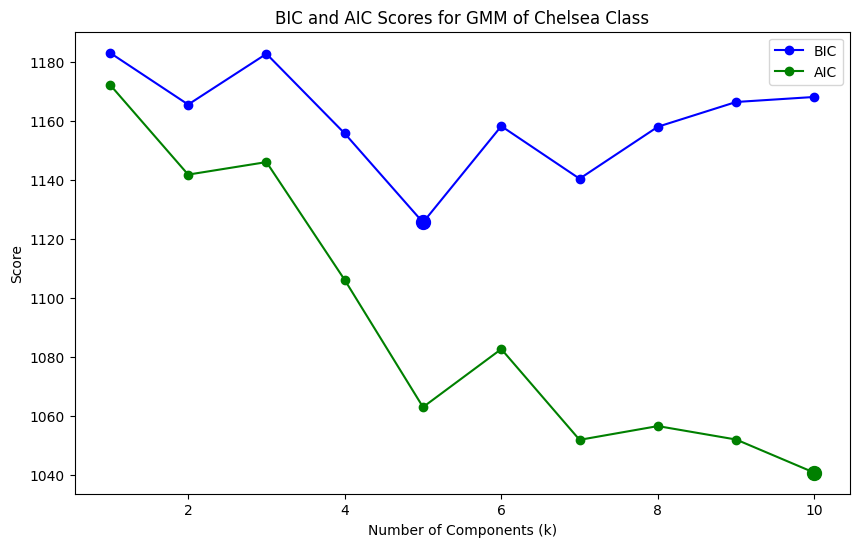

Best value of k based on BIC: 5
Best value of k based on AIC: 10


In [70]:
evaluate_gmm(ch_features, "Chelsea Class")

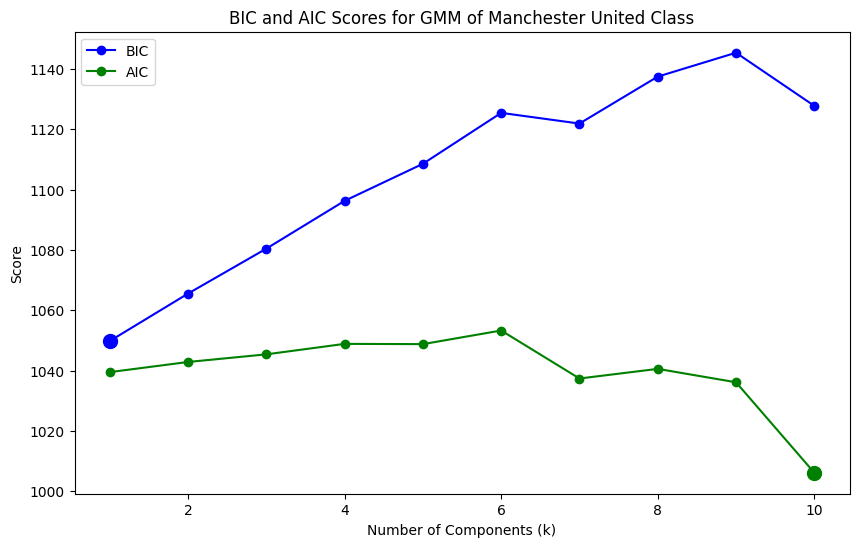

Best value of k based on BIC: 1
Best value of k based on AIC: 10


In [71]:
evaluate_gmm(mu_features, "Manchester United Class")

### $\color{deepskyblue}{\text{Using KFold}}$

In [91]:
from sklearn.model_selection import GridSearchCV, KFold
def cross_val_gmm(X):
    param_grid = {'n_components': range(1, 11)}

    # Create the GMM model
    gmm = GaussianMixture(random_state=0)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(gmm, param_grid=param_grid, cv=KFold(n_splits=5, random_state=0, shuffle=True))
    grid_search.fit(X)

    # Retrieve the results
    results = grid_search.cv_results_
    k_values = results['param_n_components'].data.astype(int)
    mean_scores = results['mean_test_score']

    # Plot the mean scores
    plt.plot(k_values, mean_scores, 'bo-')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Mean Score')
    plt.title('Cross-validated Mean Scores for GMM')
    plt.show()

    # Find the best value of k
    best_k = k_values[np.argmax(mean_scores)]

    # Print the best value of k
    print("Best value of k:", best_k)

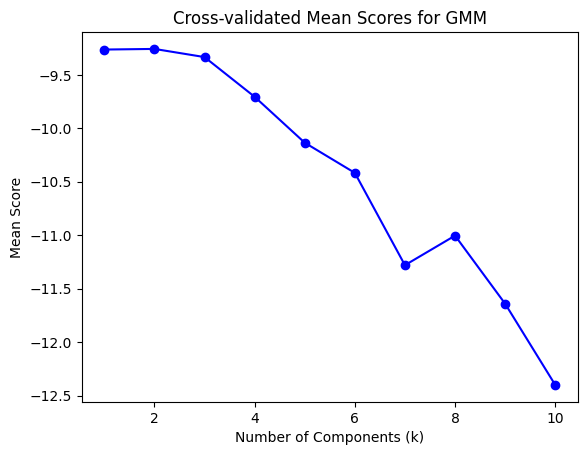

Best value of k: 2


In [92]:
cross_val_gmm(ch_features)

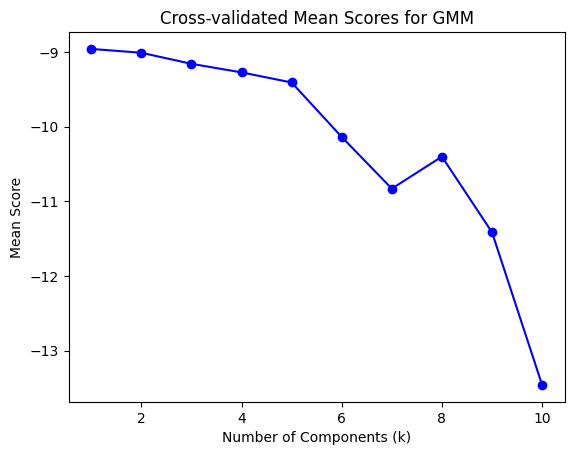

Best value of k: 1


In [93]:
cross_val_gmm(mu_features)